In [234]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime

from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data
### 1A - Load data from /data

In [2]:
dt = "2021-09-01"

eth_data = EthereumData(start_date=dt, end_date=dt, save_path=f"data/{dt}")

In [3]:
eth_data.load()

Loading blocks...
Loading transactions...
Loading contracts...
Loading logs...
Loading receipts...
Loading token_transfers...
Loading tokens...


### 1B - Determine lagged block numbers

In [15]:
pit = eth_data.point_in_time_blocks(lag=60)

In [16]:
pit.tail()

,datetime,lag_cutoff,latest_avail_block
number,,,
13142877,2021-09-01 23:58:31,2021-09-01 23:57:31,13142873.0
13142878,2021-09-01 23:58:48,2021-09-01 23:57:48,13142874.0
13142879,2021-09-01 23:59:42,2021-09-01 23:58:42,13142877.0
13142880,2021-09-01 23:59:49,2021-09-01 23:58:49,13142878.0
13142881,2021-09-01 23:59:54,2021-09-01 23:58:54,13142878.0


## 2. Derive a block-level features

### 2A - Get blocks data

In [96]:
# blocks dataset
blocks_df = eth_data.blocks.set_index('number').sort_index()
blocks_df.head()

,hash,parent_hash,nonce,sha3_uncles,logs_bloom,transactions_root,state_root,receipts_root,miner,difficulty,total_difficulty,size,extra_data,gas_limit,gas_used,timestamp,transaction_count,base_fee_per_gas
number,,,,,,,,,,,,,,,,,,
13136427,0x1c3d38ad2873c0f281079850e70df67d557af60856ba...,0xc902c6182d6f0b6c5662b50170668ccfe70620d5757d...,0x07d513dbda4cc93f,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x3aa3696f158108f9b68e9fefbf05ff8dcae232b97fdf...,0x011b82a4198dc9937b496f7b02e5c62c8e3a6ce58533...,0xe685d2e2f9ad896b406796445fcbf2beb4c259f5a25e...,0x9a319e351917874113d70f2cf3c86438202ea42184c1...,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,8409848555241209,29853078656530319963926,160051,0xd883010a08846765746888676f312e31362e37856c69...,30029266,30015153,1630454412,333,124202762367
13136428,0x6426cbb21bddc0934e73267132826043a654135dab55...,0x1c3d38ad2873c0f281079850e70df67d557af60856ba...,0x70e96f255d67bcaf,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x80a101a2403244518004047084111a0184019a204180...,0xb8f758c6b2840173f52f1c55de7b7df677f9b2152ec3...,0xa63915d5cd2cd2c67daa1d3d3455d0894f8fe48cf22a...,0x92b0f888b8c09265b0e10f7410a65b075296de9a341e...,0xea674fdde714fd979de3edf0f56aa9716b898ec8,8401640107478779,29853087058170427442705,35643,0x65746865726d696e652d6575726f70652d7765737433,30000000,7393588,1630454440,67,139713514618
13136429,0x1025103470c75a669b02ff29ea99056c4804e401abd1...,0x6426cbb21bddc0934e73267132826043a654135dab55...,0xf9d63a09a02a237b,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x100000000000008000000008000a0000400000000000...,0xf312c9bb4ace0cd553ad987ca3b1ee0c0123a217169f...,0x785b8a58ce673085521687f8f3468d6581e5d2775bef...,0xce766a8699a08bf3315507212dde49f0b5a30897ec5a...,0x829bd824b016326a401d083b33d092293333a830,8405746765779804,29853095463917193222509,8983,0xe4b883e5bda9e7a59ee4bb99e9b1bc0b0921,30029295,1164952,1630454444,9,130857526667
13136430,0x4cbb6f647eb936cb60bb884801d495645a99d22476da...,0x1025103470c75a669b02ff29ea99056c4804e401abd1...,0xb8dfd70a6131457c,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x492401ba0000402010830004a0010221180203015400...,0xc811dd6729d521d2df1a51aaf930066acf18586cb982...,0x8f5a3a9fafb298ed46ca6567def270e0faf139f6eeba...,0x3c7105e6ac201c5fe4a46d2e8174dab921e08ab5c786...,0x0708f87a089a91c65d48721aa941084648562287,8409855429285078,29853103873772622507587,28133,0x73706964657230380a3a3843,30000000,7933734,1630454446,78,115769452729
13136431,0x40aa76a3056da154d217fe3a86557b3f498efeb31427...,0x4cbb6f647eb936cb60bb884801d495645a99d22476da...,0xc00349689a041feb,0x1dcc4de8dec75d7aab85b567b6ccd41ad312451b948a...,0x30f2f1ff5908f9b391ca3102ffb8dfd360eada9cf385...,0xd57ee073f4ca6111a8a19895cbf4735b10f75879c929...,0x470290655f21516251b1a0288b7a598bfffec171fc36...,0x23df64c82f4345b862d898494ceb1fd7e8e01fa0fdad...,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,8413966098973704,29853112287738721481291,166713,0xd883010a08846765746888676f312e31362e37856c69...,30000000,29985451,1630454448,402,108952304832


Discard some columns...

In [101]:
keep_cols = [
    'difficulty', 'total_difficulty', 'size', 'gas_limit', 'gas_used', 'transaction_count', 'base_fee_per_gas'
]
blocks_df = blocks_df[keep_cols]
blocks_df.head()

,difficulty,total_difficulty,size,gas_limit,gas_used,transaction_count,base_fee_per_gas
number,,,,,,,
13136427,8409848555241209,29853078656530319963926,160051,30029266,30015153,333,124202762367
13136428,8401640107478779,29853087058170427442705,35643,30000000,7393588,67,139713514618
13136429,8405746765779804,29853095463917193222509,8983,30029295,1164952,9,130857526667
13136430,8409855429285078,29853103873772622507587,28133,30000000,7933734,78,115769452729
13136431,8413966098973704,29853112287738721481291,166713,30000000,29985451,402,108952304832


### 2B - Create some features

This example calculates the rolling 5-block mean of base_fee_per_gas

In [133]:
block_feature_df = blocks_df.rolling(5).mean()
block_feature_df.columns = [i + "_mean_5" for i in blocks_df.columns]

### 2C - Lag the features by the point-in-time block numbers

In [301]:
lagged_features = lagged_block_data(block_feature_df, pit)
lagged_features.tail()

,difficulty_mean_5_lagged,total_difficulty_mean_5_lagged,size_mean_5_lagged,gas_limit_mean_5_lagged,gas_used_mean_5_lagged,transaction_count_mean_5_lagged,base_fee_per_gas_mean_5_lagged
number,,,,,,,
13142877,8.284458e+15,2.990665e+22,97634.4,30011718.0,21173035.2,331.8,8.710222e+10
13142878,8.285270e+15,2.990665e+22,117439.0,30005859.0,21789922.4,343.2,9.150861e+10
13142879,8.278001e+15,2.990668e+22,124057.2,30023441.8,21179043.0,227.8,1.088666e+11
13142880,8.275579e+15,2.990669e+22,125910.0,30023436.0,20827050.6,227.4,1.137266e+11
13142881,8.275579e+15,2.990669e+22,125910.0,30023436.0,20827050.6,227.4,1.137266e+11


Now the `lagged features` data should match the `block_feature_df` data for the block in `latest_avail_block`.

In [303]:
pit.tail()

,datetime,lag_cutoff,latest_avail_block
number,,,
13142877,2021-09-01 23:58:31,2021-09-01 23:57:31,13142873.0
13142878,2021-09-01 23:58:48,2021-09-01 23:57:48,13142874.0
13142879,2021-09-01 23:59:42,2021-09-01 23:58:42,13142877.0
13142880,2021-09-01 23:59:49,2021-09-01 23:58:49,13142878.0
13142881,2021-09-01 23:59:54,2021-09-01 23:58:54,13142878.0


In [304]:
block_feature_df.loc[13142881]

difficulty_mean_5           8.264272e+15
total_difficulty_mean_5     2.990671e+22
size_mean_5                 8.032300e+04
gas_limit_mean_5            3.005860e+07
gas_used_mean_5             1.404093e+07
transaction_count_mean_5    1.634000e+02
base_fee_per_gas_mean_5     1.225574e+11
Name: 13142881, dtype: float64

In [305]:
block_feature_df.loc[13142878]

difficulty_mean_5           8.275579e+15
total_difficulty_mean_5     2.990669e+22
size_mean_5                 1.259100e+05
gas_limit_mean_5            3.002344e+07
gas_used_mean_5             2.082705e+07
transaction_count_mean_5    2.274000e+02
base_fee_per_gas_mean_5     1.137266e+11
Name: 13142878, dtype: float64

In [313]:
lagged_features.loc[13142881].values == block_feature_df.loc[13142878].values

array([ True,  True,  True,  True,  True,  True,  True])

## 3. Derive transaction-level features

### 3A - Get receipts data

In [255]:
receipts_df = eth_data.receipts # receipts data
receipts_df.head()

,transaction_hash,transaction_index,block_hash,block_number,cumulative_gas_used,gas_used,contract_address,root,status,effective_gas_price,transaction_id,is_vanilla
0,0xb73ba89e2711f11fa62132c2eebdc828e853700f04f8...,200,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,13993863,67483,NaN,NaN,1,93889714585,13136829_200,False
1,0x2343b30f3cde30c238c878388cd9ae7c30dd4ff8414b...,201,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14142764,148901,NaN,NaN,1,93889714585,13136829_201,False
2,0x1be38967c808e0dcb5855150eca004870e1fa43216e8...,202,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14163764,21000,NaN,NaN,1,93615785860,13136829_202,True
3,0xbe30c74511d39b8a93ce0df8591709d2873f3a5ce218...,203,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14209909,46145,NaN,NaN,1,93615785860,13136829_203,False
4,0x3f25d61048d385215215ceffe7d5966de8614d9aedd4...,204,0x8626b9f635910cf8b4a1b6a2567fee4a4b0aa30d8e3b...,13136829,14230909,21000,NaN,NaN,1,93615785860,13136829_204,True


This data is large...

In [256]:
receipts_df.shape

(1225104, 12)

Id transactions by `<block_number>_<transaction_index>` and sort by this number.

In [257]:
receipts_df['transaction_id'] = receipts_df['block_number'].astype(str) + "_" + \
    receipts_df['transaction_index'].astype(str)
receipts_df = receipts_df.set_index('transaction_id').sort_index()

Another possible feature (pct vanilla transactions)...

In [258]:
receipts_df['is_vanilla'] = receipts_df['gas_used'] == 21000

Reduce the size by removing unnecessary columns...

In [259]:
keep_cols = [
    'block_number', 'cumulative_gas_used', 'gas_used', 'status', 
    'effective_gas_price', 'is_vanilla'
]
receipts_df = receipts_df[keep_cols]

In [260]:
receipts_df.tail()

,block_number,cumulative_gas_used,gas_used,status,effective_gas_price,is_vanilla
transaction_id,,,,,,
13142881_95,13142881,8059896,175203,1,117241330377,False
13142881_96,13142881,8347559,287663,1,120372221672,False
13142881_97,13142881,8449478,101919,1,117195869288,False
13142881_98,13142881,8470478,21000,1,117195869288,True
13142881_99,13142881,8491478,21000,1,117195869288,True


### 3B - Create some features

Remove `block_number` first so you don't apply the transformation on it.

In [262]:
receipts_features = receipts_df.drop(columns='block_number').rolling(1000).mean()
receipts_features.columns = [i + "_mean_1000" for i in receipts_features.columns]
receipts_features.tail()

,cumulative_gas_used_mean_1000,gas_used_mean_1000,status_mean_1000,effective_gas_price_mean_1000,is_vanilla_mean_1000
transaction_id,,,,,
13142881_95,9953924.448,92231.954,0.963,1.304770e+11,0.310
13142881_96,9947828.639,92442.360,0.963,1.304890e+11,0.310
13142881_97,9941788.482,92498.012,0.963,1.304979e+11,0.310
13142881_98,9935513.582,92263.269,0.963,1.305068e+11,0.311
13142881_99,9929182.425,92207.012,0.963,1.305157e+11,0.312


Add back in `block_number` so you can lag by it.

In [263]:
receipts_features['block_number'] = receipts_df['block_number']
receipts_features.tail()

,cumulative_gas_used_mean_1000,gas_used_mean_1000,status_mean_1000,effective_gas_price_mean_1000,is_vanilla_mean_1000,block_number
transaction_id,,,,,,
13142881_95,9953924.448,92231.954,0.963,1.304770e+11,0.310,13142881
13142881_96,9947828.639,92442.360,0.963,1.304890e+11,0.310,13142881
13142881_97,9941788.482,92498.012,0.963,1.304979e+11,0.310,13142881
13142881_98,9935513.582,92263.269,0.963,1.305068e+11,0.311,13142881
13142881_99,9929182.425,92207.012,0.963,1.305157e+11,0.312,13142881


### 3C - Lag the features using point-in-time

Here I used `.last()` to get the data for the latest available transaction in the latest available block. You can also use other `groupby` functions like `.max()`, `.min()`, `.mean()`.

In [315]:
receipts_features_by_block = receipts_features.groupby(['block_number']).last()
receipts_features_by_block.tail()

,cumulative_gas_used_mean_1000,gas_used_mean_1000,status_mean_1000,effective_gas_price_mean_1000,is_vanilla_mean_1000
block_number,,,,,
13142877,1.234260e+07,93428.398,0.966,1.171656e+11,0.346
13142878,1.146192e+07,90535.790,0.966,1.272549e+11,0.316
13142879,9.969367e+06,91857.884,0.966,1.299560e+11,0.326
13142880,9.924649e+06,91537.948,0.968,1.301227e+11,0.327
13142881,9.929182e+06,92207.012,0.963,1.305157e+11,0.312


In [316]:
receipts_features_by_block.loc[13142874]

cumulative_gas_used_mean_1000    1.627043e+07
gas_used_mean_1000               7.029460e+04
status_mean_1000                 9.740000e-01
effective_gas_price_mean_1000    1.049680e+11
is_vanilla_mean_1000             5.290000e-01
Name: 13142874, dtype: float64

In [319]:
receipts_features_by_block_lagged = lagged_block_data(receipts_features_by_block, pit)
receipts_features_by_block_lagged .tail()

,cumulative_gas_used_mean_1000_lagged,gas_used_mean_1000_lagged,status_mean_1000_lagged,effective_gas_price_mean_1000_lagged,is_vanilla_mean_1000_lagged
number,,,,,
13142877,1.737155e+07,52070.541,0.985,9.790392e+10,0.697
13142878,1.627043e+07,70294.597,0.974,1.049680e+11,0.529
13142879,1.234260e+07,93428.398,0.966,1.171656e+11,0.346
13142880,1.146192e+07,90535.790,0.966,1.272549e+11,0.316
13142881,1.146192e+07,90535.790,0.966,1.272549e+11,0.316


### 3D - Merge lagged features with transactions

Receipts features are still on the block level...

In [332]:
receipts_features_lagged = pd.merge(
    left=receipts_features[['block_number']],
    right=receipts_features_by_block_lagged,
    how='left',
    left_on='block_number',
    right_index=True
)
receipts_features_lagged.tail()

,block_number,cumulative_gas_used_mean_1000_lagged,gas_used_mean_1000_lagged,status_mean_1000_lagged,effective_gas_price_mean_1000_lagged,is_vanilla_mean_1000_lagged
transaction_id,,,,,,
13142881_95,13142881,1.146192e+07,90535.79,0.966,1.272549e+11,0.316
13142881_96,13142881,1.146192e+07,90535.79,0.966,1.272549e+11,0.316
13142881_97,13142881,1.146192e+07,90535.79,0.966,1.272549e+11,0.316
13142881_98,13142881,1.146192e+07,90535.79,0.966,1.272549e+11,0.316
13142881_99,13142881,1.146192e+07,90535.79,0.966,1.272549e+11,0.316


In [333]:
receipts_features_lagged.shape

(1225104, 6)

## Example Model

In [371]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [402]:
clean_x = receipts_features_lagged.filter(like='lagged').dropna().sort_index()
clean_y = receipts_df['effective_gas_price'].loc[clean_features.index]

In [363]:
reg = LinearRegression().fit(clean_x, clean_y)

In [367]:
reg.score(clean_x, clean_y)

0.3617531339765909

In [403]:
clean_x.columns

Index(['cumulative_gas_used_mean_1000_lagged', 'gas_used_mean_1000_lagged',
       'status_mean_1000_lagged', 'effective_gas_price_mean_1000_lagged',
       'is_vanilla_mean_1000_lagged'],
      dtype='object')

In [405]:
pd.Series(reg.coef_, index=clean_x.columns)

cumulative_gas_used_mean_1000_lagged    7.312198e+02
gas_used_mean_1000_lagged               1.822809e+06
status_mean_1000_lagged                -1.062498e+11
effective_gas_price_mean_1000_lagged    6.442315e-01
is_vanilla_mean_1000_lagged             1.714716e+11
dtype: float64

In [372]:
pred_y = reg.predict(clean_x)

In [374]:
mean_squared_error(clean_y, pred_y)

2.4343709896861565e+22

In [375]:
r2_score(clean_y, pred_y)

0.3617531339765909

In [388]:
clean_x['effective_gas_price'] = clean_y 
clean_x['predicted_gas_price'] = pred_y 

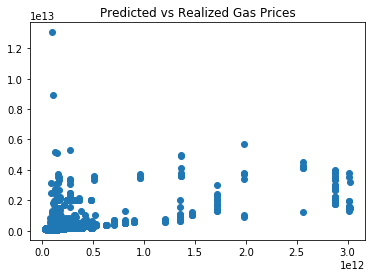

In [397]:
sample_results = clean_x[['effective_gas_price', 'predicted_gas_price']].sample(50000)
plt.scatter(sample_results['predicted_gas_price'], sample_results['effective_gas_price'])
plt.title('Predicted vs Realized Gas Prices');